# EJEMPLOS OPTIMIZACIÓN DE CARTERAS (MARKOWITZ)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import interp1d

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = [12, 8]



pd.options.display.float_format = '{:.4%}'.format

### **Ejercicio 1: Cálculo de la cartera con Mínimo Riesgo**

**Objetivo**: Minimizar el riesgo de un portafolio de inversión.

### Datos:
- **Retornos Esperados**: Un array `retornos_esperados` que contiene el retorno esperado para cada activo.
- **Matriz de Covarianza**: `matriz_cov`, describiendo la covarianza entre los activos y el riesgo combinado.


### Restricciones:
1. No se permiten posiciones cortas

Recordad que la varianza de una cartera, $ \sigma^2_p $, se calcula como:

$ \qquad \qquad \sigma^2_p = \mathbf{w}^T \Sigma \mathbf{w} $

donde:
- $ \mathbf{w} $ es el vector de pesos de la cartera. Cada elemento $ w_i $ representa la fracción del capital total invertido en el activo $ i $.
- $ \Sigma $ es la matriz de covarianza de los rendimientos de los activos. Cada elemento $ \sigma_{ij} $ representa la covarianza entre los rendimientos de los activos $ i $ y $ j $.

In [2]:
# Datos de retornos y covarianzas

retornos_esperados = np.array([0.17, 0.10, 0.07, 0.09])  # Ejemplo de retornos esperados

matriz_cov = np.array([[1.83977374, 1.23002575, 1.59282297, 0.69409837],
       [1.23002575, 1.45345954, 1.7548078 , 1.31477996],
       [1.59282297, 1.7548078 , 2.14425197, 1.55568552],
       [0.69409837, 1.31477996, 1.55568552, 1.46502412]])

In [3]:
# Variable de decisión
pesos = cp.Variable(4)

En `cvxpy`, `cp.quad_form(x, P)` toma dos argumentos:

- `x`: Una variable o vector de variables en el problema de optimización.
- `P`: Una matriz que define cómo las variables en `x` se combinan y se cuadran.

La forma cuadrática resultante se calcula como $x^T P x$, donde $x^T$ es la transpuesta del vector `x` y `P` es la matriz dada.


In [4]:
# Función objetivo
riesgo = cp.quad_form(pesos, matriz_cov)
objetivo = cp.Minimize(riesgo)

In [5]:
# Restricciones
constraints = [cp.sum(pesos) == 1, 
               pesos >= 0]

In [6]:
# Problema de optimización
problema = cp.Problem(objetivo, constraints)

# Resolviendo el problema
resultado = problema.solve()

# Resultados
pesos_optimos = pesos.value

In [7]:
print(f'El riesgo de la cartera es: {riesgo.value:.2f}')
print(f'La rentabilidad de la cartera es: {100*(retornos_esperados @ pesos_optimos).round(4)}%')
print(f'Los pesos que hacen que la cartera tenga el menor riesgo son: {100*pesos_optimos.round(2)}')

El riesgo de la cartera es: 1.15
La rentabilidad de la cartera es: 12.22%
Los pesos que hacen que la cartera tenga el menor riesgo son: [40. -0. -0. 60.]


### Apartados adicionales
- Resolver el problema anterior si además quieres una rentabilidad mínima del 14%

In [8]:
constraints.append(retornos_esperados @ pesos >= 0.14)

In [9]:
# Problema de optimización
problema = cp.Problem(objetivo, constraints)

# Resolviendo el problema
resultado = problema.solve()

# Resultados
pesos_optimos = pesos.value

In [10]:
print(f'El riesgo de la cartera es: {riesgo.value:.2f}')
print(f'La rentabilidad de la cartera es: {(100*(retornos_esperados @ pesos_optimos)).round(2)}%')
print(f'Los pesos que hacen que la cartera tenga el menor riesgo son: {100*pesos_optimos.round(2)}')

El riesgo de la cartera es: 1.25
La rentabilidad de la cartera es: 14.0%
Los pesos que hacen que la cartera tenga el menor riesgo son: [62. -0. -0. 38.]


- ¿Y si la rentabilidad mínime es del 18%?

In [11]:
# Restricciones
constraints = [cp.sum(pesos) == 1, 
               pesos >= 0,
               retornos_esperados @ pesos >= 0.18]


# Problema de optimización
problema = cp.Problem(objetivo, constraints)

# Resolviendo el problema
resultado = problema.solve()

# Resultados
pesos_optimos = pesos.value

In [12]:
print(f'Los pesos que hacen que la cartera tenga el menor riesgo son: {100*pesos_optimos.round(2)}')

AttributeError: 'NoneType' object has no attribute 'round'

In [13]:
resultado

inf

Las restricciones establecidas en este problema de optimización hacen que no tenga solución.

Dado que el rendimiento más alto de los activos es del 17%, es imposible lograr una rentabilidad del 18% con una cartera formada por estos activos.

---

### **Ejercicio 2:  Cálculo de la cartera con Máxima Rentabilidad dado un Riesgo**

**Objetivo**: Maximizar la rentabilidad de un portafolio de inversión asegurando un riesgo máximo.

### Datos (los del ejercicio anterior):
- **Retornos Esperados**: Un array `retornos_esperados` que contiene el retorno esperado para cada activo.
- **Matriz de Covarianza**: `matriz_cov`, describiendo la covarianza entre los activos y el riesgo combinado.


### Restricciones:
1. No se permiten posiciones cortas
2. El riesgo debe ser menor que 1.2

In [14]:
num_act = len(retornos_esperados)
# Variable de decisión
pesos = cp.Variable(num_act)

In [15]:
# Función objetivo
rentabilidad = retornos_esperados @ pesos
objetivo = cp.Maximize(rentabilidad)

In [16]:
# Restricciones
riesgo = cp.quad_form(pesos, matriz_cov)

constraints = [cp.sum(pesos) == 1, 
               pesos >= 0,
               riesgo <= 1.20]

riesgo = cp.quad_form(pesos, matriz_cov)

### Descargamos los datos y hacemos cálculos iniciales

In [4]:
# Date range
start = '2015-01-01'
end = '2019-12-30'

# Assets todos con retornos positivos
assets_positivos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'HPQ', 'JCI', 'JPM',
        'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 'T', 'TGT', 'TMO',
        'TXT', 'VZ', 'ZION']

assets_muy_negativos = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'GE', 'HPQ', 
        'JCI', 'JPM','KHC', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets_un_negativo = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'HPQ', 
        'JCI', 'JPM', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

assets = assets_muy_negativos



# Downloading data
prices = yf.download(assets, start = start, end = end)['Adj Close']
prices.columns = assets

[*********************100%%**********************]  26 of 26 completed


In [5]:
#Número de activos
num_act = prices.shape[1]

In [6]:
#Calculamos los retornos logaritmicos
returns = np.log(prices / prices.shift(1)).dropna()
returns.head(2)

,BA,BAX,BMY,CMCSA,CNP,CPB,DE,F,GE,HPQ,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-07,1.8543%,-2.4752%,1.0757%,0.6420%,1.9578%,1.4908%,0.7402%,0.4049%,0.6063%,0.7495%,...,1.6490%,0.3577%,2.2569%,0.3248%,0.4483%,1.8162%,0.4285%,-0.3387%,0.4455%,-2.1060%
2015-07-08,-0.8629%,-1.6574%,-0.7208%,-1.3205%,-1.9578%,-0.8582%,-1.3805%,-3.2857%,-2.2155%,-1.1429%,...,0.1168%,-2.3246%,0.3109%,-2.3935%,-1.0230%,-1.1552%,-2.1224%,-2.8682%,-0.2573%,-2.6208%


In [7]:
#Calculamos la matriz de covarianzas y los retornos esperados
matriz_cov = returns.cov().to_numpy() # Covariance matrix
retornos_esperados = returns.mean().to_numpy() # Column vector expected return

Vemos las correlaciones entre los activos

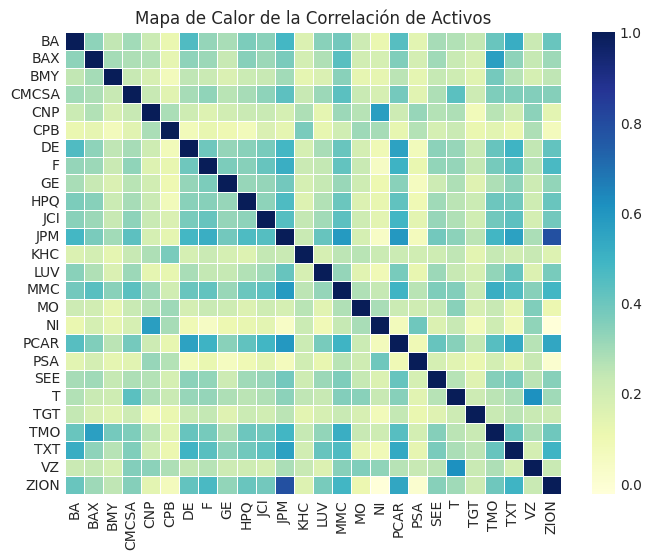

In [8]:
# Correlation matrix
mat_corr = returns.corr().to_numpy() 

# Configurando el tamaño de la figura
plt.figure(figsize=(8, 6))
sns.heatmap(mat_corr, linewidths=.5, cmap="YlGnBu", xticklabels=assets, yticklabels=assets)
# Añadiendo título
plt.title("Mapa de Calor de la Correlación de Activos")

# Mostrando la gráfica
plt.show()

Hacemos la gráfica de rentabilidad-riesgo de los activos

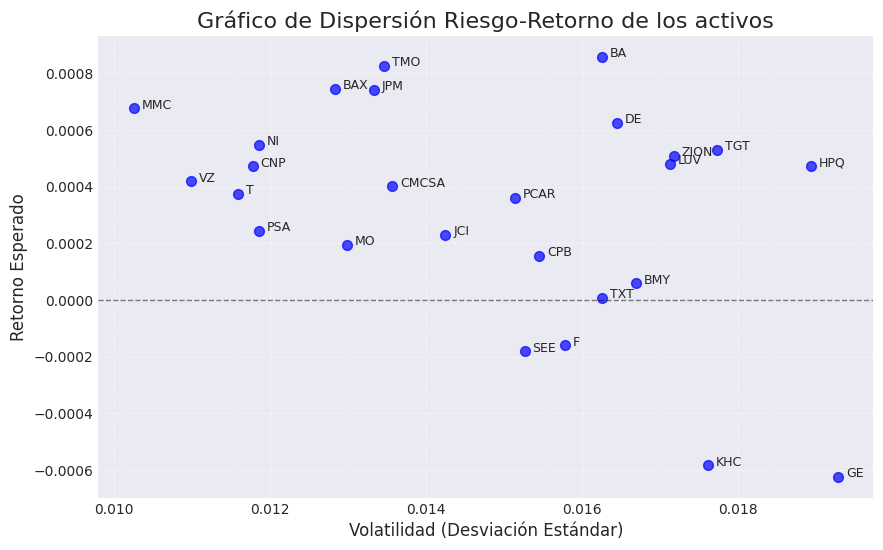

In [7]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

plt.axhline(0, color='black', lw=1, linestyle='--', alpha=0.5)

# Añadiendo títulos y etiquetas
plt.title('Gráfico de Dispersión Riesgo-Retorno de los activos', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()


## EJEMPLOS DE CARTERAS EN DONDE **NO SE PERMITEN POSICIONES CORTAS**

## 1. Cálculo de la cartera de **mínimo riesgo**

Como hemos visto, el efecto de la diversificación, nos permite reducir el riesgo de una inversión.

Si el número de activos es muy alto, podríamos eliminar todo el riesgo de los activos pero no el de mercado.

Veamos cuál es el riesgo mínimo que podemos lograr con los actvos que hemos elegido, para ello calculamos la cartera con menor riesgo:

El **riesgo de una cartera** se mide por la volatilidad o desviación estándar $\sigma_p$.

La desviación estándar es la raíz cuadradad de la varianza: $\sigma_p = \sqrt{\sigma^2_p}$

Recordad que la varianza de una cartera, $ \sigma^2_p $, se calcula como:

$ \qquad \qquad \sigma^2_p = \mathbf{w}^T \Sigma \mathbf{w} $

donde:
- $ \mathbf{w} $ es el vector de pesos de la cartera. Cada elemento $ w_i $ representa la fracción del capital total invertido en el activo $ i $.
- $ \Sigma $ es la matriz de covarianza de los rendimientos de los activos. Cada elemento $ \sigma_{ij} $ representa la covarianza entre los rendimientos de los activos $ i $ y $ j $.

In [8]:
#Variables de decisión
pesos = cp.Variable(num_act)

In [11]:
#Restricciones
constraints = [pesos >= 0,  # No shorting
               cp.sum(pesos) == 1, # Fully invested
               ]

La función cp.quad_form(pesos, matriz_cov) de la librería cvxpy es:

$\qquad \qquad cp.quad\_form(pesos, matriz\_cov) = pesos^T*matriz\_cov*pesos = \sigma^2_{cartera}$

In [12]:
#Función Objetivo

riesgo = cp.quad_form(pesos, matriz_cov) # Riesgo de la cartera
objective = cp.Minimize(riesgo) # Minimizar la varianza

In [13]:
#Problema y resuelvo
prob = cp.Problem(objective, constraints)
resultado = prob.solve()

In [14]:
#Guardamos los valores de la rentabilidad y riesgo de la cartera de mínimo riesgo
ret = retornos_esperados.T @ pesos 
min_riesgo = np.array([riesgo.value, ret.value])

In [15]:
print(f'Los pesos que hacen que la cartera tenga el mínimo riesgo son: {pesos.value}')

Los pesos que hacen que la cartera tenga el mínimo riesgo son: [-1.52300121e-19  7.18327339e-02  3.84882071e-02  1.82478151e-02
  6.19055299e-02  3.86456697e-02  2.27080833e-04  5.16934331e-03
  3.81698627e-03 -4.85714676e-19  3.56266547e-02  3.94726355e-02
  2.69981596e-19  2.92425877e-02  1.03708200e-01  7.00226102e-02
  1.06629413e-01 -1.09175466e-19  1.56191378e-01  4.59058118e-03
  8.12779466e-02  4.68248315e-02 -3.26452625e-19 -4.18270934e-19
  8.66569725e-02  1.42282247e-03]


#### Ajustemos los pesos y mostremos los componentes de la cartera

In [33]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])
pesos_ajustados

array([0.   , 0.072, 0.038, 0.018, 0.062, 0.039, 0.   , 0.005, 0.004,
       0.   , 0.036, 0.039, 0.   , 0.029, 0.104, 0.07 , 0.107, 0.   ,
       0.156, 0.005, 0.081, 0.047, 0.   , 0.   , 0.087, 0.001])

In [34]:
activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]

pesos_filtrados = [x for x in pesos_ajustados if x > 0]


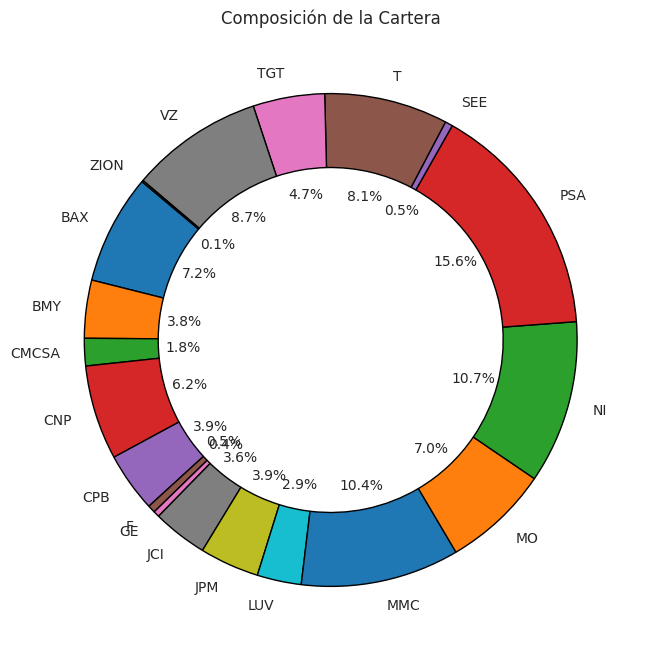

In [35]:
# Crear el gráfico de donut
plt.figure(figsize=(8, 8))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

## 2. Cáculo de la cartera de **máxima rentabilidad**

Ahora se trata de calcular la cartera de mayor rentabilidad teniendo en cuenta que no se permiten posiciones cortas


In [52]:
#Variables de decisión
pesos = cp.Variable(num_act)

In [53]:
#Restricciones
constraints = [pesos >= 0,  # No shorting
               cp.sum(pesos) == 1, # Fully invested
               ]

In [54]:
# Cálculo de la cartera de máxima rentabilidad

ret = retornos_esperados.T @ pesos 

objective = cp.Maximize(ret)

prob = cp.Problem(objective, constraints)
resultado = prob.solve(solver=cp.ECOS)

In [55]:
#Guardamos los valores de la rentabilidad y riesgo de la cartera de máxima rentabilidad

max_ret = np.array([riesgo.value, ret.value])

#### Ajustemos los pesos y mostremos los componentes de la cartera

In [56]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

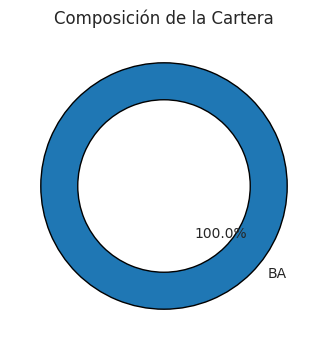

In [57]:
# Crear el gráfico de donut
plt.figure(figsize=(4, 4))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

Vamos a representar estas carteras junto con los activos

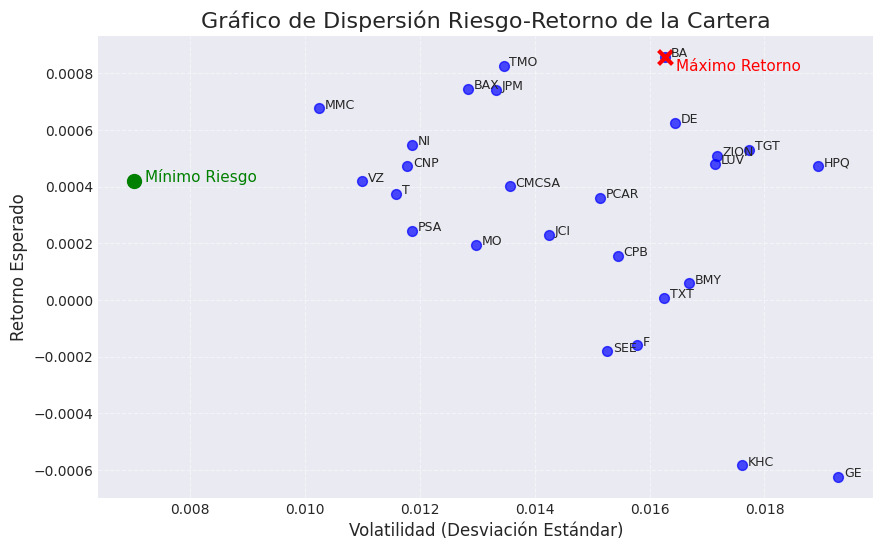

In [26]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00005  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)


# Punto de mínimo riesgo
plt.scatter(np.sqrt(min_riesgo[0]), min_riesgo[1], color='green', s=100, marker='o', label='Mínimo Riesgo')
plt.text(np.sqrt(min_riesgo[0]) + 2*desplazamiento_x, min_riesgo[1], 'Mínimo Riesgo', fontsize=11, color='green')

# Punto de máximo retorno
plt.scatter(np.sqrt(max_ret[0]), max_ret[1], color='red', s=100, marker='x', linewidths=3, label='Máximo Retorno')
plt.text(np.sqrt(max_ret[0]) + 2*desplazamiento_x, max_ret[1] - desplazamiento_y, 'Máximo Retorno', fontsize=11, color='red')

# Añadiendo títulos y etiquetas
plt.title('Gráfico de Dispersión Riesgo-Retorno de las Carteras', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()


---

### 3. Cáculo de la cartera de **máxima rentabilidad dado un riesgo máximo permitido**

Se trata de encontrar la cartera que, no excediendo el riesgo máximo definido, genere la máxima rentabilidad.

In [118]:
#riesgo máximo
riesgo_obj = 0.012

In [119]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Función objetivo
rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

#Restricciones
riesgo = cp.quad_form(pesos, matriz_cov)

constraints = [pesos >= 0,
                cp.sum(pesos) == 1,
                riesgo <= riesgo_obj**2
                ]

prob = cp.Problem(rentabilidad, constraints)
resultado = prob.solve(solver=cp.ECOS)

#### Ajustemos los pesos y mostremos los componentes de la cartera

In [120]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

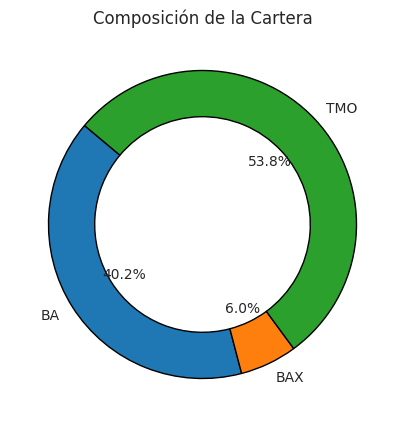

In [121]:
# Crear el gráfico de donut
plt.figure(figsize=(5, 5))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

Veamos la cartera junto a los distintos activos

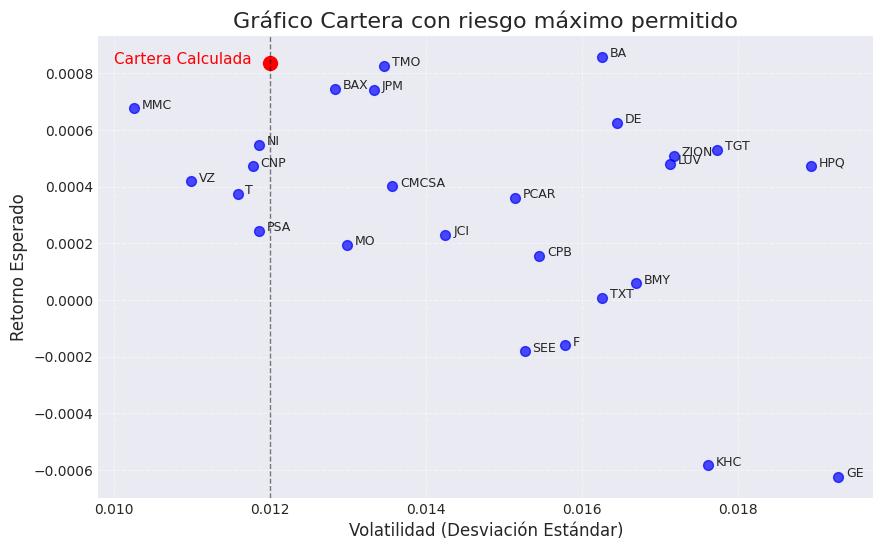

In [122]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(np.sqrt(riesgo.value), resultado, color='red', s=100, marker='o')
plt.text(np.sqrt(riesgo.value) - 20 * desplazamiento_x, resultado, 'Cartera Calculada', fontsize=11, color='red')

plt.axvline(riesgo_obj, color='black', lw=1, linestyle='--', alpha=0.5)


# Añadiendo títulos y etiquetas
plt.title('Gráfico Cartera con riesgo máximo permitido', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

---

### 4. Cáculo de la cartera de **máxima rentabilidad según tolerancia al riesgo**

Los inversores tienen distintos niveles de tolerancia al riesgo, conocida como aversión al riesgo.

Ahora vamos a calcular las carteraas con la mayor rentabilidad para distintos niveles de aversión al riesgo.

- El factor $\Large \boldsymbol{\gamma}$ representa la aversión al riesgo de un inversor.

- Hay que tener en cuenta que $\Large \boldsymbol{\gamma}$ $\geq 0$ 
  
- Un $\Large \boldsymbol{\gamma}$ bajo indica mayor tolerancia al riesgo para buscar altos rendimientos.
  
- Un $\Large \boldsymbol{\gamma}$ alto muestra preferencia por inversiones seguras con rendimientos menores.
  
- $\Large \boldsymbol{\gamma}$ equilibra riesgo y rendimiento en la selección de carteras.


Nota: Este ejemplo se basa en la documentación de la librería [CVXPY Documentation](https://www.cvxpy.org/)


In [9]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Factor aversión al riesgo
gamma = cp.Parameter(nonneg=True)

ret = retornos_esperados.T @ pesos

riesgo = cp.quad_form(pesos, matriz_cov)

Definimos la **función objetivo**:

- La función objetivo busca maximizar las ganancias, pero reduce la rentabilidad si hay mucho riesgo.

- Restar el riesgo multiplicado por el factor gamma hace que, a igual rentabilidad, se elijan carteras menos riesgosas.

- Con un gamma alto, que indica poca tolerancia al riesgo, se prioriza la seguridad aunque las ganancias sean menores.

In [10]:
objetivo = cp.Maximize(ret - gamma*riesgo)

In [11]:
#Restricciones y función objetivo
constraints = [pesos >= 0,
                cp.sum(pesos) == 1
                ]

prob = cp.Problem(objetivo, constraints)

In [12]:
#resolvemos para diferentes valores de gamma
num_sim = 100
riesgos_res = np.zeros(num_sim)
retornos_res = np.zeros(num_sim)
pesos_res = np.zeros((num_sim, num_act))
gamma_vals = np.logspace(-2, 3, num=num_sim)

for i in range(num_sim):
    gamma.value = gamma_vals[i]
    prob.solve()
    retornos_res[i] = ret.value
    riesgos_res[i] = cp.sqrt(riesgo).value
    pesos_res[i, :] = pesos.value


Vamos a interpolar los puntos calculados

In [13]:
# Crear un diccionario para mapear riesgos a retornos y quedarme con un array sin duplicados
riesgo_retorno_dict = dict(zip(riesgos_res, retornos_res))
x = np.array(list(riesgo_retorno_dict.keys()))
y = np.array(list(riesgo_retorno_dict.values()))

In [14]:
#Interpolo los puntos y obtengo la frontera eficiente

frontera_eficiente = interp1d(x, y, kind='cubic')
x_nuevos = np.linspace(min(riesgos_res), max(riesgos_res), num=500)
y_nuevos = frontera_eficiente(x_nuevos)

Ahora representamos todo

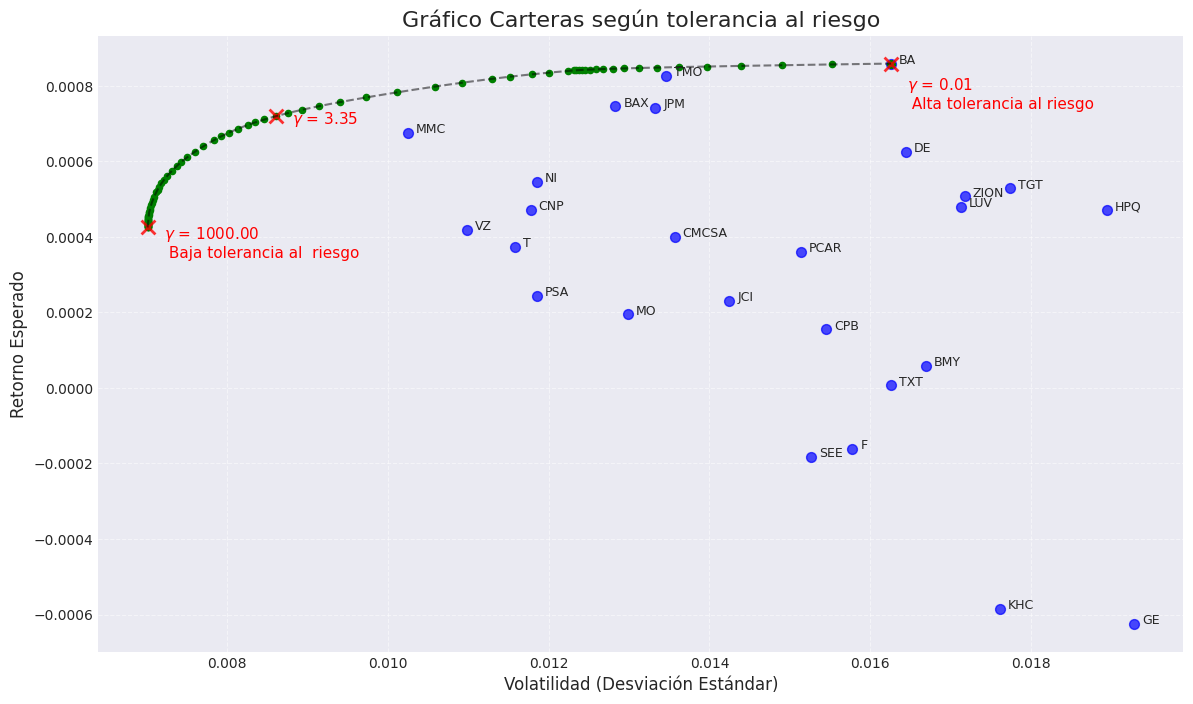

In [15]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')#,  alpha=0.3)   

plt.plot(x_nuevos, y_nuevos, '--', color='black', label='Frontera Eficiente', alpha=0.5)

plt.scatter(riesgos_res[num_sim-1], retornos_res[num_sim-1], color='red', s=100, marker='x',  linewidths=2, alpha=0.8, label = f'$\gamma$ = {gamma_vals[num_sim-1]:.2f}')
plt.text(riesgos_res[num_sim-1] + 2*desplazamiento_x, retornos_res[num_sim-1] - 4 * desplazamiento_y, f'$\gamma$ = {gamma_vals[num_sim-1]:.2f} \n Baja tolerancia al  riesgo', fontsize=11, color='red')

plt.scatter(riesgos_res[int(num_sim/2)], retornos_res[int(num_sim/2)], color='red', s=100, marker='x',  linewidths=2, alpha=0.8, label = f'$\gamma$ = {gamma_vals[int(num_sim/2)]:.2f}')
plt.text(riesgos_res[int(num_sim/2)] + 2*desplazamiento_x, retornos_res[int(num_sim/2)] - desplazamiento_y, f'$\gamma$ = {gamma_vals[int(num_sim/2)]:.2f}', fontsize=11, color='red')

plt.scatter(riesgos_res[int(0)], retornos_res[int(0)], color='red', s=100, marker='x',  linewidths=2, alpha=0.8, label = f'$\gamma$ = {gamma_vals[int(0)]:.2f}')
plt.text(riesgos_res[int(0)] + 2*desplazamiento_x, retornos_res[int(0)] - 6*desplazamiento_y, f'$\gamma$ = {gamma_vals[0]:.2f}\n Alta tolerancia al riesgo', fontsize=11, color='red')

# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras según tolerancia al riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()



#### Mostremos los componentes de la cartera según varía la aversión al riesgo

/tmp/ipykernel_39357/1718662018.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  paleta = cm.get_cmap('tab20c', num_act)


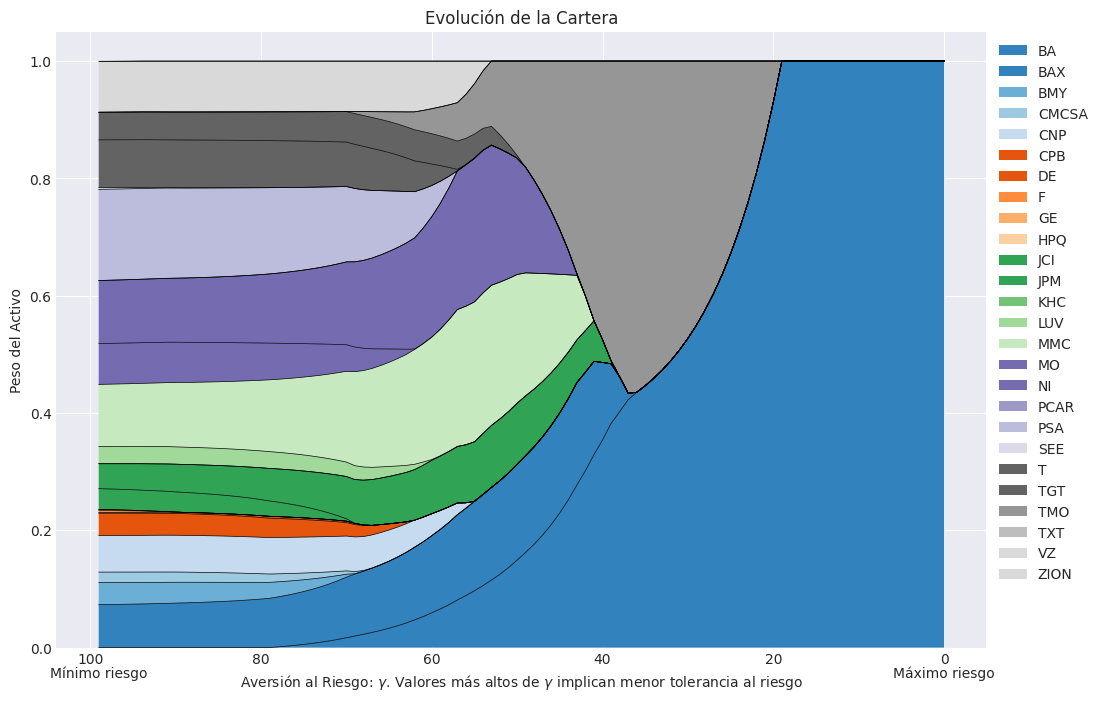

In [16]:
# Elegir una paleta de colores y generar colores
from matplotlib import cm
paleta = cm.get_cmap('tab20c', num_act)
colores = [paleta(i) for i in range(num_act)]

# Crear una gráfica de áreas apiladas
tiempo = np.arange(num_sim)  # Eje x - tiempo

plt.stackplot(tiempo, pesos_res.T, colors=colores, labels=[f'{assets[i]}' for i in range(num_act)])

# Añadir bordes a las áreas
for i in range(num_act):
    plt.plot(tiempo, np.sum(pesos_res[:, :i+1], axis=1), color='black', linewidth=0.5)

# Invertir el eje x
plt.gca().invert_xaxis()

# Añadir texto personalizado en el eje x
plt.text(num_sim-1, -0.05, 'Mínimo riesgo', ha='center')  # Cerca del 100
plt.text(0, -0.05, 'Máximo riesgo', ha='center')         # Cerca del 0


plt.xlabel('Aversión al Riesgo: $\gamma$. Valores más altos de $\gamma$ implican menor tolerancia al riesgo')
plt.ylabel('Peso del Activo')
plt.title('Evolución de la Cartera')

# Ajustar la leyenda fuera del área del gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show();

---

### 5. Carteras con restricciones en la cantidad máxima invertida en un activo

Se trata de calcular la cartera con mayor rentabilidad posible pero asegurando que no se invierte más de un porcentaje en un solo activo

In [146]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Función objetivo
rentabilidad = cp.Maximize(retornos_esperados.T @ pesos)

# #Restricciones

max_inv = 0.1 # Máxima inversión en un activo

constraints =   [pesos >= 0,
                cp.sum(pesos) == 1,
                pesos <= max_inv
                ]

prob = cp.Problem(rentabilidad, constraints)
resultado = prob.solve(solver=cp.ECOS)

#### Ajustemos los pesos y mostremos los componentes de la cartera

In [147]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

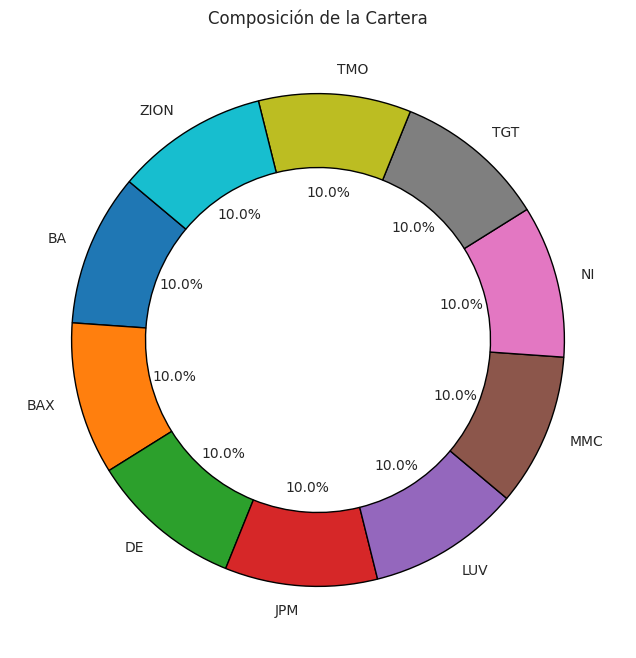

In [148]:
# Crear el gráfico de donut
plt.figure(figsize=(8, 8))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

#### Vamos a representar estas carteras junto con los activos

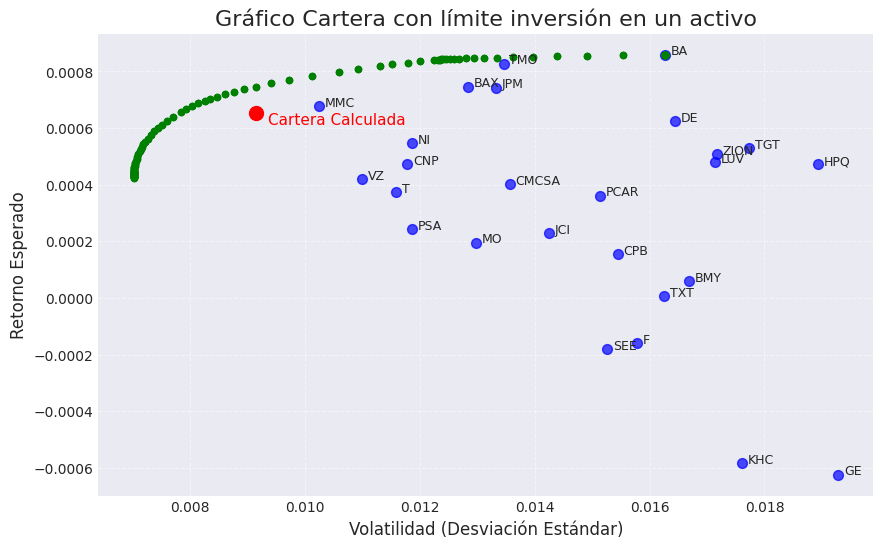

In [150]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')#,  alpha=0.3)   


plt.scatter(np.sqrt(cp.quad_form(pesos, matriz_cov).value), resultado, color='red', s=100, marker='o', label='Cartera Calculada')
plt.text(np.sqrt(cp.quad_form(pesos, matriz_cov).value) + 2*desplazamiento_x, resultado - 2*desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')

# Añadiendo títulos y etiquetas
plt.title('Gráfico Cartera con límite inversión en un activo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

---

### 6. Carteras con restricciones en número mínimo de activos y de rentabilidad esperada

Se busca encontrar una cartera que no solo supere un determinado nivel de rentabilidad, sino que también incluya un número mínimo de activos, promoviendo así la diversificación.

In [12]:
# Definimos el retorno mínimo deseado como un factor del retorno máximo
factor = 0.8
minimum_return = factor * retornos_esperados.max()


In [20]:
#Variables de decisión
pesos = cp.Variable(num_act)

# The risk (variance) of the portfolio
riesgo = cp.quad_form(pesos, matriz_cov)


In [21]:
# Constraints

# 1. The sum of the weights is 1 (fully invested portfolio)
constraint_sum_of_weights = cp.sum(pesos) == 1

# 2. The expected return of the portfolio is at least the minimum desired return
constraint_expected_return = retornos_esperados.T @ pesos >= minimum_return

# 3. No short selling (pesos are non-negative)
constraint_no_short_selling = pesos >= 0


Ahora definimos las restricciones que aseguran tener un número mínimo de activos:

**Inclusión de al menos 5 activos**: 

  - Se utilizan variables binarias para la selección ($selection$).

  - Estas variables valen 1 si el activo forma parte de la cartera o 0 en caso contrario
  
  - $constraint\_minimum\_assets = cp.sum(selection) >= 5$ asegura que al menos 5 activos sean incluidos.

**Vinculación de variables de selección con los pesos**:

  - $constraint\_link\_selection\_weights = weights \leq selection$ crea una relación entre cada peso y su variable de selección.
   
    - Si un activo no está seleccionado ($selection[i] = 0$), su peso ($weights[i]$) se establece en cero. Esto impide que activos no seleccionados influyan en la cartera.
  
    - Si un activo está seleccionado ($selection[i] = 1$), su peso puede ser positivo, permitiendo su inclusión en la cartera.
  
    - Este método asegura que solo los activos seleccionados tengan un impacto en la composición de la cartera.

In [22]:
# 4. At least 5 assets must be included in the portfolio
# We use binary variables for selection
min_act = 5
selection = cp.Variable(num_act, boolean=True)
constraint_minimum_assets = cp.sum(selection) >= min_act

# Link the selection variables with the weights
# This ensures that weights are set to zero for assets that are not selected
constraint_link_selection_weights = pesos <= selection

# The pesos must be either 0 or greater than a small positive value if the asset is selected
# This ensures that if an asset is selected, it has a meaningful weight in the portfolio
small_positive_value = 1e-4
constraint_weight_significance = pesos >= small_positive_value * selection

In [23]:
# Problem
problem = cp.Problem(cp.Minimize(riesgo), 
                     [constraint_sum_of_weights,
                      constraint_expected_return,
                      constraint_no_short_selling,
                      constraint_minimum_assets,
                      constraint_link_selection_weights,
                      constraint_weight_significance])

# Solve the problem
resultado = problem.solve(solver=cp.GUROBI) #Hay que indicar el solver ya que hay variables binarias

#resultado = problem.solve(solver=cp.ECOS_BB) #Hay que indicar el solver ya que hay variables binarias


#### Ajustemos los pesos y mostremos los componentes de la cartera

In [24]:
pesos_ajustados = np.array([np.round(x, 3) if x > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x > 0]

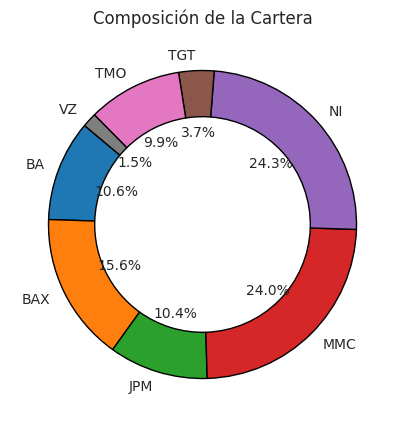

In [25]:
# Crear el gráfico de donut
plt.figure(figsize=(5, 5))

plt.pie(pesos_filtrados, labels=activos_filtrados, autopct='%1.1f%%', startangle=140, wedgeprops={'width': 0.3, 'edgecolor': 'black'})

# Añadir título
plt.title('Composición de la Cartera')

# Mostrar el gráfico
plt.show()

In [30]:
# Calculo la rentabilidad de la cartera
ret = (retornos_esperados.T @ pesos).value


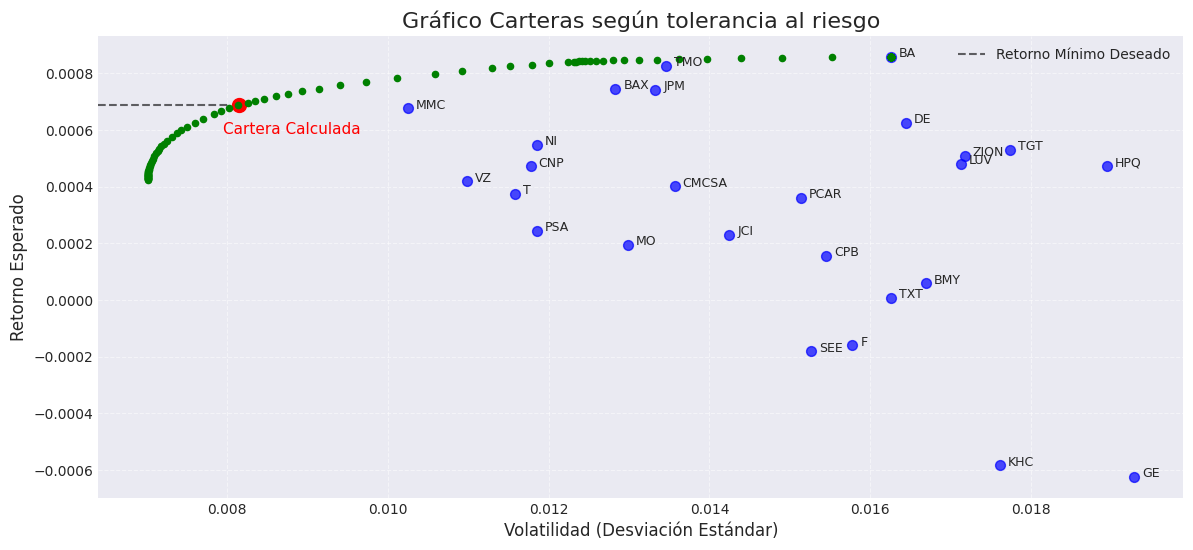

In [32]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(14, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.0001  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i], asset, fontsize=9)

#plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')#,  alpha=0.3)   
    
plt.axhline(xmin = 0, xmax = 0.12, y=minimum_return, color='black', linestyle='--', label='Retorno Mínimo Deseado', alpha=0.6)


plt.scatter(np.sqrt(resultado), ret, color='red', s=100, marker='o')
plt.text(np.sqrt(resultado) - 2*desplazamiento_x, ret - desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')

# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras según tolerancia al riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

---

## EJEMPLOS DE CARTERAS EN DONDE **SE PERMITEN POSICIONES CORTAS**

### 7. Carteras con posiciones cortas pero límite de endeudamiento

Calcular la cartera de máxima rentabilidad, permitiendo posiciones cortas pero con un máximo endeudamiento

Ponerse en corto en una acción implica los siguientes pasos:

1. **Seleccionar una Acción**: Elige una acción que crees que disminuirá de valor.
   
2. **Pedir Prestada la Acción**: Solicita prestada la acción a través de tu corredor de bolsa, acordando un plazo para la devolución.
   
3. **Vender la Acción**: Vende la acción prestada en el mercado abierto.
   
4. **Recomprar la Acción**: Si el precio cae, recompra la acción a un precio más bajo antes del plazo acordado.
   
5. **Devolver la Acción**: Devuelve la acción al prestamista al finalizar el plazo pactado.
   
6.  **Beneficio**: La ganancia es la diferencia entre el precio de venta y de recompra, menos comisiones y costos.


Esto me permite conseguir financiación e invertirlo en otro activo.

Primero, veamos las rentabilidades de cada uno de los activos

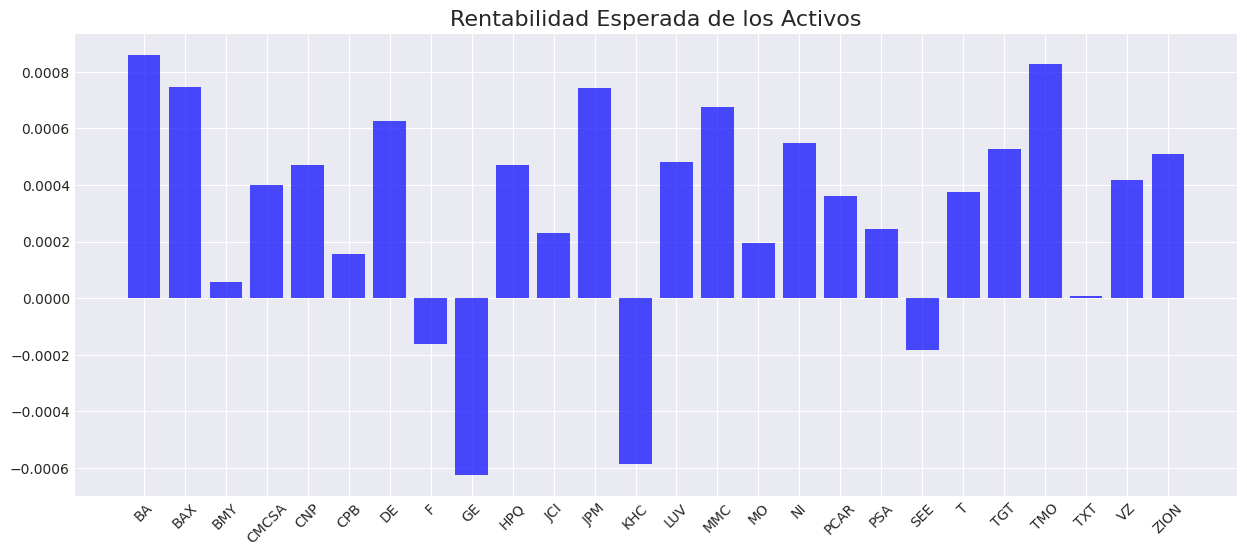

In [133]:
plt.figure(figsize=(15, 6))

plt.bar(range(len(retornos_esperados)), retornos_esperados, color='blue', alpha=0.7)

# Añadiendo los nombres de los activos como etiquetas en el eje x
plt.xticks(range(len(assets)), assets, rotation=45)

plt.title('Rentabilidad Esperada de los Activos', fontsize=16);

In [42]:
pesos = cp.Variable(num_act)

# Restricciones
constraints = [
    cp.sum(pesos) == 1,                 # La suma de los pesos debe ser igual a 1
    cp.sum(cp.abs(pesos)) <= 1.5        # El endeudamiento total no debe superar el 30%
]

# Función objetivo (maximizar el retorno esperado)
retorno_esperado = retornos_esperados @ pesos
objetivo = cp.Maximize(retorno_esperado)

# Definir y resolver el problema
problema = cp.Problem(objetivo, constraints)
resultado = problema.solve(solver=cp.ECOS)

riesgo = cp.quad_form(pesos, matriz_cov)


In [43]:
pesos.value

array([ 1.24999925e+00,  3.20786924e-08,  1.17600381e-09,  5.13235844e-09,
        6.66960287e-09,  1.92483507e-09,  1.27857530e-08,  7.34477040e-10,
       -2.49999172e-01,  6.66326758e-09,  2.67343450e-09,  3.08142515e-08,
       -7.48130514e-07,  6.89909994e-09,  1.72781643e-08,  2.30723626e-09,
        8.94156279e-09,  4.43994984e-09,  2.82565642e-09,  8.39299535e-10,
        4.64187996e-09,  8.30914700e-09,  5.03717045e-07,  8.83276374e-10,
        5.48175808e-09,  7.65229580e-09])

In [46]:
pesos_ajustados = np.array([np.round(x, 3) if np.abs(x) > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x != 0]

In [48]:
print(f'Los activos que forman parte de la cartera son {np.array(assets)[pesos_ajustados != 0].tolist()}')

print(f'Los pesos que hacen que la cartera tenga el máximo retorno son: {pesos_ajustados[pesos_ajustados != 0].round(2)}')

print(f'Los retornos de los activos que forman parte de la cartera son: {retornos_esperados[pesos_ajustados != 0].round(4)}')

Los activos que forman parte de la cartera son ['BA', 'GE']
Los pesos que hacen que la cartera tenga el máximo retorno son: [ 1.25 -0.25]
Los retornos de los activos que forman parte de la cartera son: [ 0.0009 -0.0006]


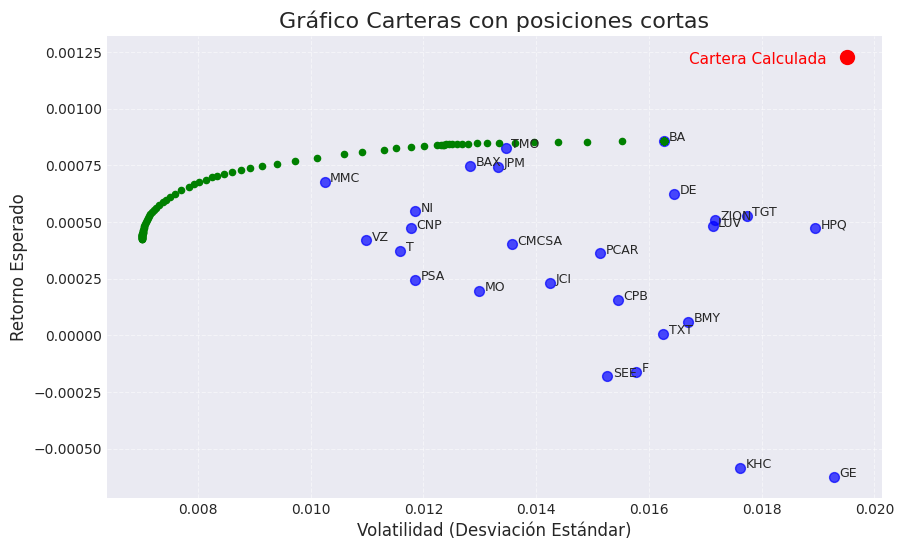

In [53]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(np.sqrt(riesgo.value), resultado, color='red', s=100, marker='o')
plt.text(np.sqrt(riesgo.value) - 28*desplazamiento_x, resultado - desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')


# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras con posiciones cortas', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

### 8. Cáculo de la cartera de **máxima rentabilidad según tolerancia al riesgo** variando el límite de posiciones cortas permitidas

In [31]:
cortas_max = [1.0, 1.3, 1.5, 1.7, 2.0]
resultados_df = pd.DataFrame()
num_sim = 100


In [32]:
for deuda in cortas_max:
    riesgos_res_short = np.zeros(num_sim)
    retornos_res_short = np.zeros(num_sim)
    gamma_vals = np.logspace(-2, 3, num=num_sim)

    for i in range(num_sim):
        pesos = cp.Variable(num_act)
        gamma = cp.Parameter(nonneg=True)
        gamma.value = gamma_vals[i]
        
        ret = retornos_esperados.T @ pesos
        riesgo = cp.quad_form(pesos, matriz_cov)
        objetivo = cp.Maximize(ret - gamma * riesgo)

        constraints = [cp.sum(pesos) == 1,
                       cp.sum(cp.abs(pesos)) <= deuda]
        prob = cp.Problem(objetivo, constraints)
        prob.solve()

        # Verificar el estado del problema
        if prob.status not in ["infeasible", "unbounded"]:
            retornos_res_short[i] = ret.value
            riesgos_res_short[i] = cp.sqrt(riesgo).value
        else:
            print(f"Problema no resuelto para gamma={gamma.value}: {prob.status}")

    resultados_df[f'riesgo_{deuda}'] = riesgos_res_short
    resultados_df[f'retorno_{deuda}'] = retornos_res_short

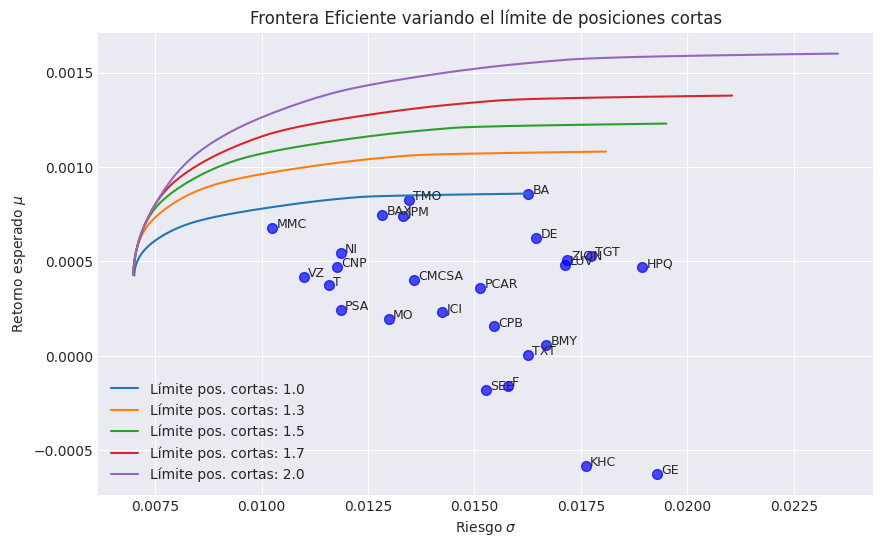

In [34]:
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

for deuda in cortas_max:
    plt.plot(resultados_df[f'riesgo_{deuda}'], resultados_df[f'retorno_{deuda}'], label=f'Límite pos. cortas: {deuda}')

plt.xlabel('Riesgo $\sigma$')
plt.ylabel('Retorno esperado $\mu$')
plt.title('Frontera Eficiente variando el límite de posiciones cortas')
plt.legend(loc='best')
plt.show()


In [22]:
resultados_df = pd.DataFrame()

for deuda in deuda_max:
    #Variables de decisión
    pesos = cp.Variable(num_act)

    # Factor aversión al riesgo
    gamma = cp.Parameter(nonneg=True)

    

    riesgo = cp.quad_form(pesos, matriz_cov)

        # Restricciones
    constraints = [
        cp.sum(pesos) == 1,                 # La suma de los pesos debe ser igual a 1
        cp.sum(cp.abs(pesos)) <= deuda
           ]       # El endeudamiento total no debe superar el 30%

    # Función objetivo (maximizar el retorno esperado)

    objetivo = cp.Maximize(ret - gamma*riesgo)

    # Definir y resolver el problema
    prob = cp.Problem(objetivo, constraints)

    num_sim = 100
    riesgos_res_short = np.zeros(num_sim)
    retornos_res_short = np.zeros(num_sim)
    pesos_res_short = np.zeros((num_sim, num_act))
    gamma_vals = np.logspace(-2, 3, num=num_sim)

    for i in range(num_sim):
        gamma.value = gamma_vals[i]
        prob.solve()
        print(ret.value)
        retornos_res_short[i] = ret.value
        riesgos_res_short[i] = cp.sqrt(riesgo).value
        pesos_res_short[i, :] = pesos.value
        resultados_df[f'riesgo_{deuda}'] = riesgos_res_short
        resultados_df[f'retorno_{deuda}'] = retornos_res_short
        resultados_df[f'pesos_{deuda}'] = pesos_res_short
    

    

None


ValueError: Expected a 1D array, got an array with shape (100, 26)

In [60]:
# Restricciones
constraints = [
    cp.sum(pesos) == 1,                 # La suma de los pesos debe ser igual a 1
    cp.sum(cp.abs(pesos)) <= 1.5        # El endeudamiento total no debe superar el 30%
]

# Función objetivo (maximizar el retorno esperado)

objetivo = cp.Maximize(ret - gamma*riesgo)

# Definir y resolver el problema
prob = cp.Problem(objetivo, constraints)


In [61]:
num_sim = 100
riesgos_res_short = np.zeros(num_sim)
retornos_res_short = np.zeros(num_sim)
pesos_res_short = np.zeros((num_sim, num_act))
gamma_vals = np.logspace(-2, 3, num=num_sim)

for i in range(num_sim):
    gamma.value = gamma_vals[i]
    prob.solve()
    retornos_res_short[i] = ret.value
    riesgos_res_short[i] = cp.sqrt(riesgo).value
    pesos_res_short[i, :] = pesos.value


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


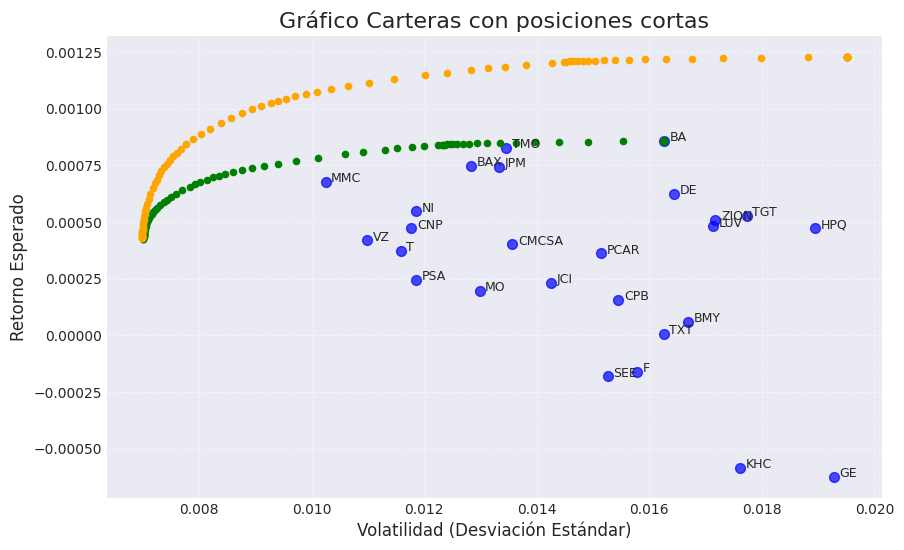

In [63]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')

plt.scatter(riesgos_res_short, retornos_res_short, color='orange', s=20, marker='o')


# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras con posiciones cortas', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

---

Ahora volvemos al ejemplo inicial donde todos los activos tienen ganancias.

¿Podremos ganar más usando posiciones cortas en este caso?

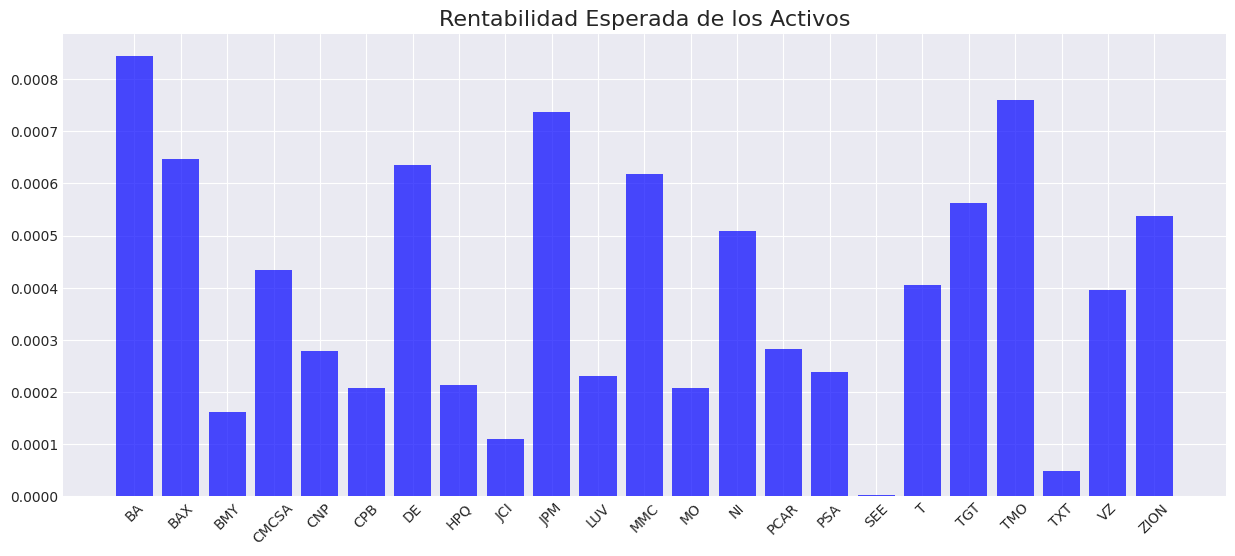

In [175]:
plt.figure(figsize=(15, 6))

plt.bar(range(len(retornos_esperados)), retornos_esperados, color='blue', alpha=0.7)

# Añadiendo los nombres de los activos como etiquetas en el eje x
plt.xticks(range(len(assets)), assets, rotation=45)

plt.title('Rentabilidad Esperada de los Activos', fontsize=16);





In [176]:
pesos = cp.Variable(num_act)

# Restricciones
constraints = [
    cp.sum(pesos) == 1,                 # La suma de los pesos debe ser igual a 1
    cp.sum(cp.abs(pesos)) <= 1.3        # El endeudamiento total no debe superar el 30%
]

# Función objetivo (maximizar el retorno esperado)
retorno_esperado = retornos_esperados @ pesos
objetivo = cp.Maximize(retorno_esperado)

# Definir y resolver el problema
problema = cp.Problem(objetivo, constraints)
resultado = problema.solve(solver=cp.ECOS)

riesgo = cp.quad_form(pesos, matriz_cov)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


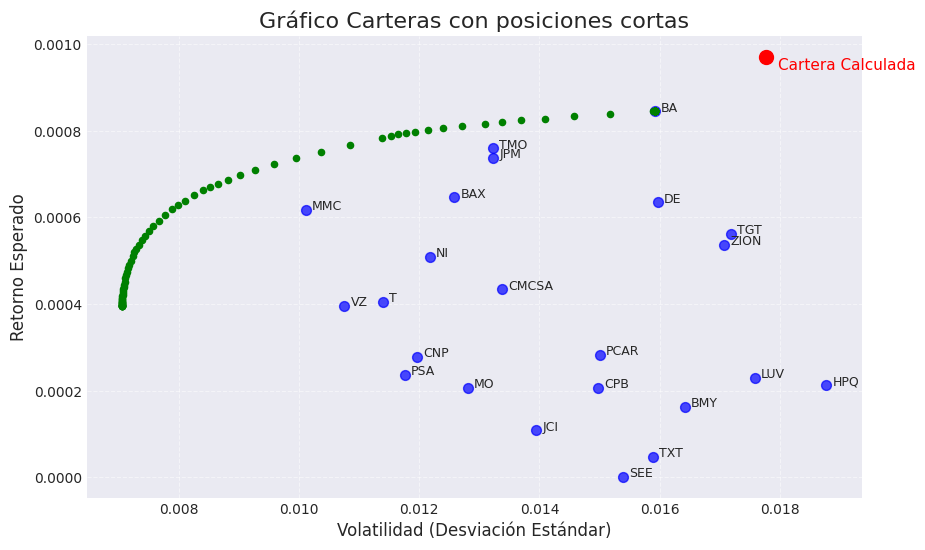

In [177]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(np.sqrt(riesgo.value), resultado, color='red', s=100, marker='o')
plt.text(np.sqrt(riesgo.value) + 2*desplazamiento_x, resultado - desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')


# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras con posiciones cortas', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

---

In [135]:
#Variables de decisión
pesos = cp.Variable(num_act)

# Factor aversión al riesgo
gamma = cp.Parameter(nonneg=True)

ret = retornos_esperados.T @ pesos

riesgo = cp.quad_form(pesos, matriz_cov)

objetivo = cp.Maximize(ret - gamma*riesgo)

In [136]:
max_apalancamiento = 1.3# Restricciones
constraints = [
    cp.sum(pesos) == 1,                 # La suma de los pesos debe ser igual a 1
    cp.sum(cp.abs(pesos)) <= max_apalancamiento       # El endeudamiento total no debe superar el 30%
]

prob = cp.Problem(objetivo, constraints)

In [137]:
#resolvemos para diferentes valores de gamma
num_sim = 100
riesgos_res_short = np.zeros(num_sim)
retornos_res_short = np.zeros(num_sim)
gamma_vals = np.logspace(-2, 3, num=num_sim)
gamma_vals = np.unique(gamma_vals)

for i in range(num_sim):
    gamma.value = gamma_vals[i]
    prob.solve()
    retornos_res_short[i] = ret.value
    riesgos_res_short[i] = cp.sqrt(riesgo).value

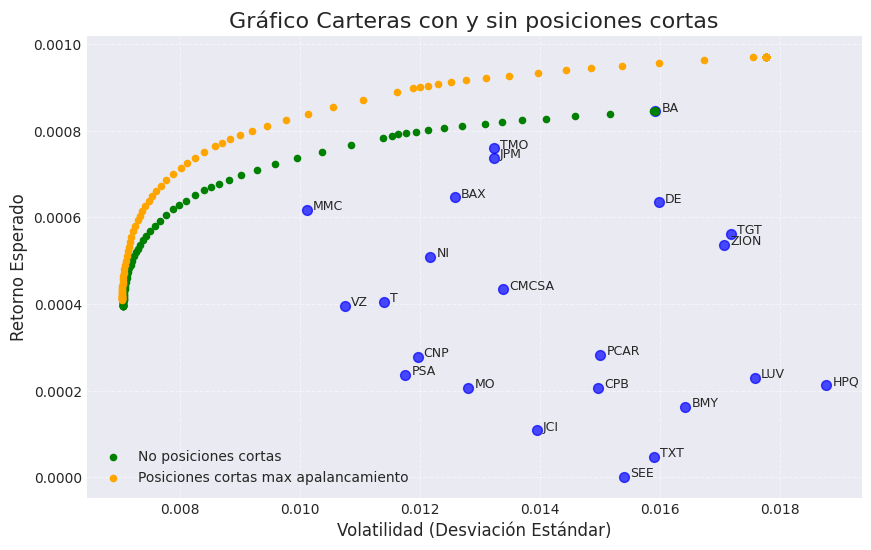

In [143]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-darkgrid')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o', label='No posiciones cortas')#,  alpha=0.3)   

plt.scatter(riesgos_res_short, retornos_res_short, color='orange', s=20, marker='o', label='Posiciones cortas max apalancamiento')#,  alpha=0.3)


# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras con y sin posiciones cortas', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

plt.legend(loc='best')

# Mostrar el gráfico
plt.show()

---

In [5]:
cp.installed_solvers()

['CLARABEL', 'ECOS', 'ECOS_BB', 'GUROBI', 'OSQP', 'SCIPY', 'SCS']